In [25]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.onnx as onnx
import torchvision.models as models
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


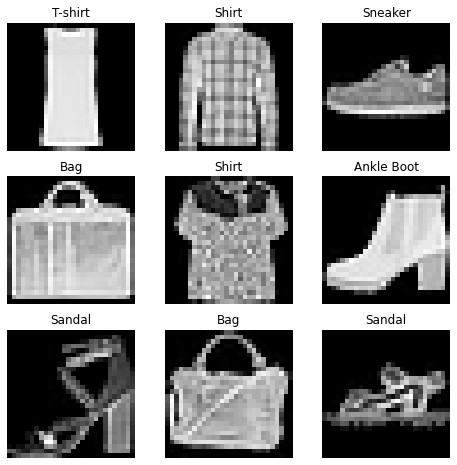

In [2]:
labels_map = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
#prepare the data for algo
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [4]:
ds

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Target transform: Lambda()

In [5]:
#determine on each hardware to run model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [6]:
#define and build model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device) 
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)

In [7]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([4])


In [8]:
#undesting network layers

#get three images from dataset each 28x28pixels
input_image = torch.rand(3, 28, 28, device=device)
print(input_image.size())

torch.Size([3, 28, 28])


In [9]:
#prepare the data  input for the nn 
flatten = nn.Flatten()
flat_img = flatten(input_image)
print(flat_img.size())

torch.Size([3, 784])


In [10]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_img)
print(hidden1.size())

torch.Size([3, 20])


In [11]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.0639,  0.1215,  0.4435,  0.2232, -0.1627, -0.7225, -0.2739,  0.3244,
          0.3910,  0.2856, -0.3736, -0.4547,  0.2331, -0.2966,  0.0156,  0.3319,
         -0.1463,  0.4576,  0.1728, -0.0232],
        [ 0.0436,  0.2890,  0.4476,  0.1607, -0.3441, -0.5084, -0.3745,  0.1871,
          0.5076, -0.0897, -0.3460, -0.5528,  0.4028, -0.4121,  0.0429,  0.1202,
         -0.3479,  0.5641,  0.2193, -0.3601],
        [ 0.0140,  0.1185,  0.5113, -0.0075, -0.4606, -0.4864, -0.0583,  0.3895,
          0.2470, -0.4362, -0.2618, -0.5993,  0.4051, -0.4131,  0.0974,  0.1219,
         -0.3249,  0.3480,  0.1970, -0.1699]], grad_fn=<AddmmBackward>)


After ReLU: tensor([[0.0639, 0.1215, 0.4435, 0.2232, 0.0000, 0.0000, 0.0000, 0.3244, 0.3910,
         0.2856, 0.0000, 0.0000, 0.2331, 0.0000, 0.0156, 0.3319, 0.0000, 0.4576,
         0.1728, 0.0000],
        [0.0436, 0.2890, 0.4476, 0.1607, 0.0000, 0.0000, 0.0000, 0.1871, 0.5076,
         0.0000, 0.0000, 0.0000, 0.4028, 0.0000, 0.042

In [12]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_img = torch.rand(3, 28, 28)
logits = seq_modules(input_img)
logits

tensor([[-0.0688, -0.0430, -0.3530,  0.1093,  0.0873,  0.0984, -0.2349, -0.1938,
         -0.1638,  0.2917],
        [-0.1230,  0.0077, -0.1758,  0.3709,  0.2699,  0.3194, -0.3508, -0.3670,
         -0.1512,  0.2272],
        [-0.0586,  0.0332, -0.1698,  0.1078,  0.1121,  0.1745, -0.2192, -0.1578,
         -0.0270,  0.2120]], grad_fn=<AddmmBackward>)

In [13]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [14]:
#info about nn parameters

print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0125, -0.0213,  0.0016,  ..., -0.0091, -0.0327, -0.0340],
        [-0.0209, -0.0054, -0.0265,  ...,  0.0147, -0.0250, -0.0168]],
       grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0114, -0.0243], grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0255, -0.0024,  0.0003,  ...,  0.0310,  0.0347, -0.0242],
        [ 0.0131, -0.0200, -0.0014,  ...,  0.0145, -0.0179,  0.0105]],
       grad_fn=<SliceBackward>) 

Layer: linear_relu_

In [17]:
#backpropagation
x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [18]:
print('Gradient function for z =', z.grad_fn)
print('Gradient function for loss =', loss.grad_fn)

Gradient function for z = <AddBackward0 object at 0x7f6017054040>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward object at 0x7f6017054130>


In [19]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3091, 0.0828, 0.0665],
        [0.3091, 0.0828, 0.0665],
        [0.3091, 0.0828, 0.0665],
        [0.3091, 0.0828, 0.0665],
        [0.3091, 0.0828, 0.0665]])
tensor([0.3091, 0.0828, 0.0665])


In [20]:
#disable gradient tracking, optimization
#use case: model already trained and ready
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [21]:
#training and testing functions
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #Computer prediction and loos
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #Backpropagation
        optimizer.zero_grad() #initialize gradients to prevent double counting
        loss.backward() #backpropagate the prediction loss
        optimizer.step() #adjust the params by grads collected in backward pass
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [26]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [27]:
#hyperparamaters

learning_rate = 1e-3
batch_size = 64
epochs = 10

#Run model on training and testing step

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-----------------
loss: 2.299077 [    0/60000]
loss: 2.298462 [ 6400/60000]
loss: 2.287225 [12800/60000]
loss: 2.289310 [19200/60000]
loss: 2.266523 [25600/60000]
loss: 2.239930 [32000/60000]
loss: 2.254228 [38400/60000]
loss: 2.230567 [44800/60000]
loss: 2.236179 [51200/60000]
loss: 2.192834 [57600/60000]
Test Error: 
 Accuracy: 37.6%, Avg loss: 2.218336 

Epoch 2
-----------------
loss: 2.217721 [    0/60000]
loss: 2.227020 [ 6400/60000]
loss: 2.210174 [12800/60000]
loss: 2.231071 [19200/60000]
loss: 2.155915 [25600/60000]
loss: 2.116124 [32000/60000]
loss: 2.144492 [38400/60000]
loss: 2.100714 [44800/60000]
loss: 2.130549 [51200/60000]
loss: 2.025759 [57600/60000]
Test Error: 
 Accuracy: 41.7%, Avg loss: 2.086195 

Epoch 3
-----------------
loss: 2.102107 [    0/60000]
loss: 2.113802 [ 6400/60000]
loss: 2.081302 [12800/60000]
loss: 2.119014 [19200/60000]
loss: 1.956375 [25600/60000]
loss: 1.927527 [32000/60000]
loss: 1.960662 [38400/60000]
loss: 1.897248 [44800/60000]
loss: 

In [28]:
#save model
torch.save(model, 'modelZalando.pth')
